In [ ]:
#Downloading libraries
!pip install -U sentence-transformers

     |████████████████████████████████| 81kB 3.3MB/s 
     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 1.2MB 43.5MB/s 
     |████████████████████████████████| 3.3MB 47.4MB/s 
     |████████████████████████████████| 901kB 18.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=bd78f125d60e9c4e7fe8d5bb7f2ef13b33533cda701d678aadc268d2cc1c3bdf
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [ ]:
pip install umap-learn

     |████████████████████████████████| 81kB 3.0MB/s 
     |████████████████████████████████| 1.2MB 8.7MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=800919cb640579219aa90c35697d22eccc3e77b6d1d0503c061d5295fd1b4269
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=801c6eb030d05f3c232fb6065a82324b2dec2d364a95dcf9ba68c19595eb7700
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
pip install fasttext


     |████████████████████████████████| 71kB 2.2MB/s eta 0:00:011
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3096552 sha256=8615e4bc0c58015fec21914e957756f74b8ed0e518a127391c260664daf683b1
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
#Importing dependencies
import gensim
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from collections import Counter
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import os
import umap.umap_ as umap
import copy
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import contextlib
import spacy
import re
import random
import math
import fasttext.util

Util

In [ ]:
def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))

    return topics

def get_lda_topics(nlp_tokens, lda_dic, lda_model):
    def token_topic(token):
        return topic_words.get(token, -1)
    
    top = 4
    bow_text = [lda_dic.doc2bow(nlp_tokens)]
    topic_text = lda_model.get_document_topics(bow_text)
    topic_text = pd.DataFrame.from_records([{v:k for v, k in row} for row in topic_text])
    
    
    topic_words = []
    topic_labeled = 0
    for topic in topic_text.columns.values:
        topic_terms = lda_model.get_topic_terms(topic, top)
        topic_words = topic_words+[[topic_labeled, lda_dic[pair[0]], pair[1]] for pair in topic_terms]
        topic_labeled += 1
    topic_words = pd.DataFrame(topic_words, columns=['topic', 'word', 'value']).pivot(index='word', columns='topic', values='value').idxmax(axis=1)
    
    topic_labeled = 0
    topic_proba = []
    for topic in topic_text:
        
        topic_proba.append(topic_text[topic].values[0])
        
        topic_labeled += 1
    val, idx = max((val, idx) for (idx, val) in enumerate(topic_proba))
    return idx

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()


def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)


def visualize(model, mon):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    dr = 'drive/My Drive/Thesis/Data/images/{}/{}/{}'.format(mon, model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig(dr + '/2D_vis')

def get_model_wordcloud(model, ldamodel, num_topics, mon):
    """ Create a Word Cloud for each topic of the LDA model

    """ 
    topics = 'Wordclouds for the different topics'
    plot_cols = 1
    plot_rows = num_topics
    axisNum = 0
    dr = 'drive/My Drive/Thesis/Data/images/{}/{}/{}'.format(mon, model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)

    plt.figure(figsize=(25, 20))
    for topicID in range(ldamodel.state.get_lambda().shape[0]):
        #gather most relevant terms for the given topic
        topics_terms = ldamodel.state.get_lambda()
        tmpDict = {}
        for i in range(1, len(topics_terms[0])):
            tmpDict[ldamodel.id2word[i]]=topics_terms[topicID,i]

        # draw the wordcloud
        wordcloud = WordCloud( margin=0,max_words=50 ).generate_from_frequencies(tmpDict)
        axisNum += 1
        ax = plt.subplot(plot_rows, plot_cols, axisNum)

        plt.imshow(wordcloud, interpolation='bilinear')
        title = topicID
        plt.title(title)
        plt.suptitle(topics)
        plt.axis("off")
        plt.margins(x=0, y=0)
        
    plt.savefig(dr + '/Topic' + '_wordcloud')   
    plt.show()
  
    
    #print('Getting wordcloud for topic {}. Done!'.format(topic))

import numpy as np

def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

def get_wordcloud(model, token_lists, topic, mon):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    #if model.method == 'LDA':                     
    #    return
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
    tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])

    wordcloud = WordCloud(margin=0, background_color='black', collocations=False,
                          min_font_size=10, max_words=50).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(20, 15))
    ax = plt.subplot(2, 2, topic+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    dr = 'drive/My Drive/Thesis/Data/images/{}/{}/{}'.format(mon, model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig(dr + '/Topic' + str(topic) + '_wordcloud')
    print('Getting wordcloud for topic {}. Done!'.format(topic))


In [ ]:
#word2vec, glove, fasttext
class WordVecVectorizer(object):
    def __init__(self, model, method):
        self.model = model
        self.method = method

        if method == 'WORD2VEC':
          self.dim = 100 
                     
        elif method == 'GLOVE':
           self.dim = 5 
           
        elif method == 'FASTTEXT':           
            self.dim = 300
       
        
    def fit(self, X, y):
        return self    
        
    def transform(self, X):
        return np.array([
            np.mean([self.model[w] for w in texts.split() if w in self.model]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X              
        ])

In [ ]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
tweet_tokenizer = TweetTokenizer()   
from gensim.models.wrappers import FastText
from gensim.scripts.glove2word2vec import glove2word2vec

def preprocess(docs):
        """
        Preprocess the data
        """        

        print('Preprocessing texts ...')
        sentences = docs['clean_sentences']  # sentence level preprocessed
        token_lists=[] # word level preprocessed
        for sentence in sentences:
          tokens = tweet_tokenizer.tokenize(str(sentence))
          token_lists.append(tokens)

        print('Preprocessing . Done!')
        return sentences, token_lists   

# define model object
class Topic_Model:
    def __init__(self, k=4, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'WORD2VEC', 'GLOVE', 'FASTTEXT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        # self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")



    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vector representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20, random_state=13)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

        elif method == 'WORD2VEC':

            print('Getting vector representations for WORD2VEC ...')
            model = gensim.models.KeyedVectors.load_word2vec_format('drive/My Drive/Thesis/pretrained_model/word2vec/model.bin', binary=True) 
            wtv_vect = WordVecVectorizer(model, method)
            embeddings = wtv_vect.transform(sentences)
            vec = np.vstack(embeddings)
            print('Getting vector representations for WORD2VEC. Done!')
            return vec
        
        elif method == 'GLOVE':

            print('Getting vector representations for GLOVE ...')
            model = loadGloveModel("drive/My Drive/Thesis/Data/gensim_glove_vectors.txt") 
            wtv_vect = WordVecVectorizer(model, method)
            embeddings = wtv_vect.transform(sentences)
            vec = np.vstack(embeddings)
            #print('Getting vector representations for GLOVE. Done!')
            return vec

        elif method == 'FASTTEXT':

            print('Getting vector representations for FASTTEXT ...')
            #loading the model
            model = fasttext.load_model('drive/My Drive/Thesis/pretrained_model/fasttext/model.bin') 
            wtv_vect = WordVecVectorizer(model, method)
            embeddings = wtv_vect.transform(sentences)
            vec = np.vstack(embeddings)
            print('Getting vector representations for FASTTEXT. Done!')
            return vec

                         


    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')


January

In [ ]:
documents = pd.read_csv("/Data/tweet_processed.csv")
documents

,date,tweet,clean_sentences
0,2021-01-01 23:59:12+00:00,"pobga mesti balik lagi nih ke juventus, biar s...",pobga mesti juventus biar strategi om pirlo va...
1,2021-01-01 23:58:28+00:00,Sriti adalah pesawat tanpa awak ciptaan anak-a...,sriti pesawat cipta anak anak bppt indonesia p...
2,2021-01-01 23:58:05+00:00,Nonton youtube rewind Indonesia malah nangis. ...,nonton youtube rewind indonesia menang iya all...
3,2021-01-01 23:57:50+00:00,perebeutan gelar juara premier league lagi ser...,perebeutan gelar juara premier league seru ser...
4,2021-01-01 23:56:25+00:00,"Kemaren sepupu ada cerita, habis sembuh dari c...",kemarin sepupu cerita habis sembuh covid indra...
...,...,...,...
30995,2021-01-31 15:54:45+00:00,Cita-citaku itu selain keliling indonesia adal...,cita cita keliling indonesia explore asia teng...
30996,2021-01-31 15:54:42+00:00,sch! kalian skolah pake schoology gak?\n\n✄・・・...,sch skolah pakai pakai schoology trivia jahit ...
30997,2021-01-31 15:54:19+00:00,waktu smp bisa bisanya disuruh pidato tentang ...,smp suruh pidato lgbtq indonesia lesbi
30998,2021-01-31 15:53:55+00:00,Tak boleh la dengar lagu sheila on 7 - sahabat...,dengar lagu sheila on sahabat sejati rindu kat...


LDA

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=Warning)

def main():
    
    
    method = "LDA"
    ntopic = 4    
    dir = 'drive/My Drive/Thesis/Data/Cluster/'
    month = 'test1'

    data = documents 
    data = data.fillna('')  # only the comments has NaN's
    sentences, token_lists = preprocess(data)
    # Define the topic model object
    tm = Topic_Model(k = ntopic, method = method)
    # Fit the topic model by chosen method
    tm.fit(sentences, token_lists)
    # Evaluate using metrics   
    print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
    # visualize and save img
    visualize(tm, month)
    get_model_wordcloud(tm, tm.ldamodel, ntopic, month)

    topic_pred = []

    for tweet in token_lists:
      topic_pred.append(get_lda_topics(tweet, tm.dictionary, tm.ldamodel))

    data['group_cluster'] = topic_pred
    topic_0_clustered_data = data.loc[data['group_cluster'] == 0]
    topic_1_clustered_data = data.loc[data['group_cluster'] == 1]
    topic_2_clustered_data = data.loc[data['group_cluster'] == 2]
    topic_3_clustered_data = data.loc[data['group_cluster'] == 3]
    topic_0_clustered_data.to_csv(dir + month +'/lda_cluster_0.csv', encoding= 'utf-8', index= False)
    topic_1_clustered_data.to_csv(dir + month +'/lda_cluster_1.csv', encoding= 'utf-8', index= False)
    topic_2_clustered_data.to_csv(dir + month +'/lda_cluster_2.csv', encoding= 'utf-8', index= False)
    topic_3_clustered_data.to_csv(dir + month +'/lda_cluster_3.csv', encoding= 'utf-8', index= False)


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=Warning)


def main():
    
    
    method = "FASTTEXT" # Method BERT, FASTTEXT, LDA, WORD2VEC, GLOVE
    ntopic = 4
    dir = '/Data/Cluster/'
    month = 'test1'

    data = documents 
    data = data.fillna('')  # only the comments has NaN's
    sentences, token_lists = preprocess(data)
    # Define the topic model object
    tm = Topic_Model(k = ntopic, method = method)
    # Fit the topic model by chosen method
    tm.fit(sentences, token_lists)
   

    print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
    # visualize and save img
    visualize(tm, month)
    for i in range(tm.k):
        get_wordcloud(tm, token_lists, i, month)

    data['group_cluster'] = tm.cluster_model.labels_

    #data['group_cluster'] = topic_pred
    topic_0_clustered_data = data.loc[data['group_cluster'] == 0]
    topic_1_clustered_data = data.loc[data['group_cluster'] == 1]
    topic_2_clustered_data = data.loc[data['group_cluster'] == 2]
    topic_3_clustered_data = data.loc[data['group_cluster'] == 3]
    topic_0_clustered_data.to_csv(dir + month +'/fasttext_cluster_0.csv', encoding= 'utf-8', index= False)
    topic_1_clustered_data.to_csv(dir + month +'/fasttext_cluster_1.csv', encoding= 'utf-8', index= False)
    topic_2_clustered_data.to_csv(dir + month +'/fasttext_cluster_2.csv', encoding= 'utf-8', index= False)
    topic_3_clustered_data.to_csv(dir + month +'/fasttext_cluster_3.csv', encoding= 'utf-8', index= False)

Preprocessing texts ...
Preprocessing . Done!
Clustering embeddings ...
Getting vector representations for FASTTEXT ...


Getting vector representations for FASTTEXT. Done!
Clustering embeddings. Done!
Coherence: 0.482855978294748
Calculating UMAP projection ...
Calculating UMAP projection. Done!
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!


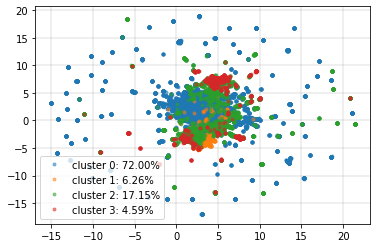

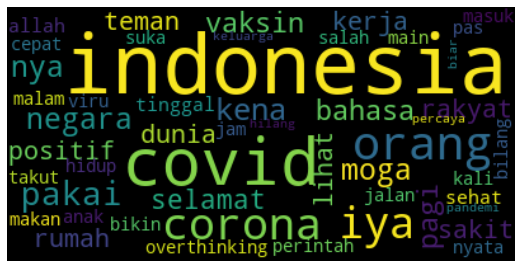

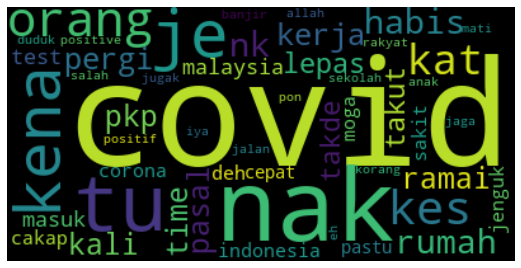

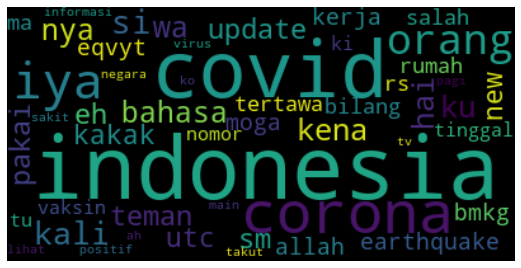

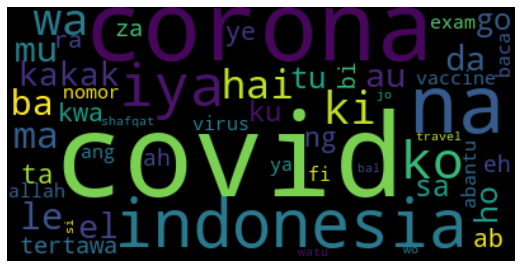

In [ ]:
#jan
main()

Combining clustered tweets

In [ ]:
tw = tw[['date','clean_sentences']]
tw['date'] = pd.to_datetime(tw['date']).dt.date
tw1 = tw.groupby(['date'], as_index = False).agg({'clean_sentences': ','.join})
combined_tweets = tw1.to_csv("/Data/Tweet_TM/test_combined.csv", index=False)

In [ ]:
t = pd.read_csv("/Data/Tweet_TM/test_combined.csv")
t

,date,clean_sentences
0,2021-01-01,kemarin sepupu cerita habis sembuh covid indra...
1,2021-01-02,aceh obat covid ganja ganja pakai bikin keju v...
2,2021-01-03,covid nomor joke kena nak real nak nomor joke ...
3,2021-01-04,last night berita matrik kes positif covid sab...
4,2021-01-05,edukasi khalayak ramai takut covid jalan proke...
5,2021-01-06,orang call malam family kasih je takat nak lak...
6,2021-01-07,orang sayang juang lawan covid nun sono doain ...
7,2021-01-08,ganyampe utbk woiii takut prepare corona nama ...
8,2021-01-09,anak dipamitin pergi kemarin kemarin baba skg ...
9,2021-01-10,iya allah berita layu wafat kiyai kabar mohon ...
